# Data load 및 분석
- 목적 : 중고차 예상 판매가격 예측
- Data 출처 : https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=CAR+DETAILS+FROM+CAR+DEKHO.csv

In [27]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/car_data.csv')
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


# Data 전처리
1. 필요 없는 Feature 분리
2. 이상치, 결측치 확인 및 수정
3. Feature, Label 분리 및 Data encoding, scaling
  - 범주형의 경우 pandas의 get_dummies() 함수 이용해 One-Hot Encoding
  - 연속형의 경우 앙상블을 위해 Feature Scaling  
  - KNN, linear regression은 Feature Scaling 필요
  - Random Forest, XGBoost는 필요 X
4. Train, Test set분리

## 1. 불필요한 column 분리

In [28]:
df.set_index('Car_Name', inplace = True)
df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
Car_Name,,,,,,,,
ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0


## 2. 이상치 , 결측치 확인 및 제거
- 이상치 제거의 경우 큰 효과 보지못함

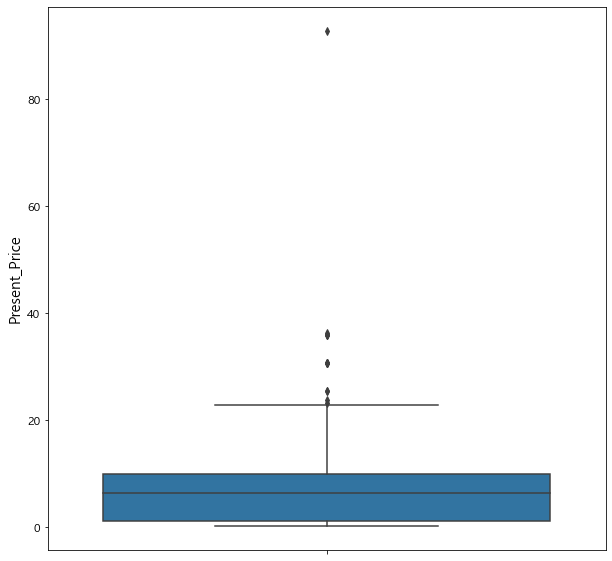

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.boxplot(y='Present_Price', data=df)
plt.show()

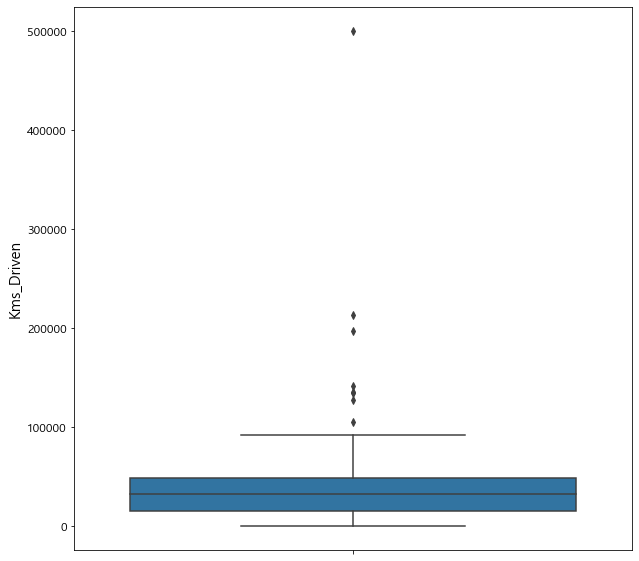

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.boxplot(y='Kms_Driven', data=df)
plt.show()

In [31]:
# max값 이상치 취급, 제거
df['Present_Price'].max()
df1 = df.drop(df[df['Present_Price'] >=90].index)
df1 = df.drop(df[df['Kms_Driven'] >=400000].index)
df1['Present_Price'].max()
df1

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
Car_Name,,,,,,,,
ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0


In [32]:
# 결측치 X
df1.isnull().count()

Year             299
Selling_Price    299
Present_Price    299
Kms_Driven       299
Fuel_Type        299
Seller_Type      299
Transmission     299
Owner            299
dtype: int64

## 3. Feature, Label 분리 및 Data encoding, scaling

## Data type 확인
  ### Feature
  - Car_Name : 차량 이름 : index로 설정
  - 범주형
    - Year : 차 구매년도, 2004년~15년까지의 value 
    - Fuel_Type : 기름 종류, (Petrol, Diesel, CNG) 총 3가지 종류  
    - Seller_Type : 판매자, (Individual, Dealer) 2가지
    - Transmission : 기어 변속기 종류, (Manual, Automatic) 2가지
    - Owner : 차량의 이전 소유자 수 (0, 1, 3), 3가지
  - 연속형
    - Kms_Driven : 달린 거리
    - Present_Price	: 현재 가격 
  
  ### Label
  - Selling_Price : 중고차 판매가격으로 예측해야되는 연속적인 값

In [33]:
df.Year.value_counts()
df.Fuel_Type.value_counts()
df.Seller_Type.value_counts()
df.Transmission.value_counts()
df.Owner.value_counts()

0    290
1     10
3      1
Name: Owner, dtype: int64

In [34]:
# ohe-hot encoding
ohe = ['Year','Fuel_Type','Seller_Type', 'Transmission', 'Owner']
df2 = pd.get_dummies(df1, columns= ohe)     
df2
y = df2['Selling_Price']
X = df2.drop(columns='Selling_Price')

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# X(Feature), y(Label) 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Feature Scaling, 연속형만 적용
scaler = StandardScaler()
X_train_scaled=X_train
X_test_scaled=X_test
var = ['Present_Price', 'Kms_Driven']
X_train_scaled[var] = scaler.fit_transform(X_train[var])
X_test_scaled[var] = scaler.transform(X_test[var])
X_test_scaled

,Present_Price,Kms_Driven,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual,Owner_0,Owner_1,Owner_3
Car_Name,,,,,,,,,,,,,,,,,,,,,
i20,0.044941,-1.109786,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,0
Hero Super Splendor,-0.795389,0.591708,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0
ciaz,0.250280,-0.728175,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
i20,-0.101252,-0.167225,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
eon,-0.364622,-0.440803,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TVS Sport,-0.800969,-0.728175,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0
verna,0.190018,0.756693,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0
brio,-0.100136,-0.678679,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,0


# 모델 선정
- 모델 선정을 위해 Ensemble Voting 방식 이용해 검증 및 상관관계 판단

## 참고
- SVM, KNN, LogisticRegression은 Feature Scaling 전처리 데이터를 사용
- Random Forest, XGBoost는 Decision Tree기반이므로 Feature Scaling이 필요없다.

## 모델 선정을 위한 테스트

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
import xgboost

# 각 model 생성
knn = KNeighborsRegressor(n_neighbors=5)
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0)
lr = LinearRegression()
xgb = xgboost.XGBRegressor(max_depth=2, random_state=0)

# 학습
knn.fit(X_train_scaled, y_train)   
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)
# 평가
pred_train_knn = knn.predict(X_train_scaled)
pred_train_rf = rf.predict(X_train)
pred_train_xgb = xgb.predict(X_train)
pred_train_lr = lr.predict(X_train_scaled)

pred_test_knn = knn.predict(X_test_scaled)
pred_test_rf = rf.predict(X_test)
pred_test_xgb = xgb.predict(X_test)
pred_test_lr = lr.predict(X_test_scaled)

C:\Users\oj\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\oj\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\oj\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [37]:
# 평가 요소 관련 함수 정의
from sklearn.metrics import mean_squared_error, r2_score
def print_regression_metrics(y, pred, title=None):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, pred)
    if title:
        print(title)
    print(f"MSE: {mse}, RMSE: {rmse}, R2: {r2}")

In [38]:
# train, test set 평가
print_regression_metrics(y_train, pred_train_knn, "Train KNN")
print_regression_metrics(y_test, pred_test_knn, "Test KNN")
print('-'*80)
print_regression_metrics(y_train, pred_train_rf, "Train RF")
print_regression_metrics(y_test, pred_test_rf, "Test RF")
print('-'*80)
print_regression_metrics(y_train, pred_train_lr, 'Train lr')
print_regression_metrics(y_test, pred_test_lr, 'Test lr')
print('-'*80)
print_regression_metrics(y_train, pred_train_xgb, 'Train XGB')
print_regression_metrics(y_test, pred_test_xgb, 'Test XGB')

Train KNN
MSE: 2.349753982142857, RMSE: 1.5328907273980286, R2: 0.9008510137064853
Test KNN
MSE: 3.5874544533333332, RMSE: 1.8940576689566062, R2: 0.8875160833401106
--------------------------------------------------------------------------------
Train RF
MSE: 0.9269656168936696, RMSE: 0.9627905363544397, R2: 0.9608862451378273
Test RF
MSE: 3.8521698116056213, RMSE: 1.9626945283476034, R2: 0.8792159862417834
--------------------------------------------------------------------------------
Train lr
MSE: 2.2602898116250882, RMSE: 1.503426024660039, R2: 0.9046259969106154
Test lr
MSE: 3.9523538491793953, RMSE: 1.9880527782680708, R2: 0.8760747357869857
--------------------------------------------------------------------------------
Train XGB
MSE: 0.1903783635291583, RMSE: 0.43632369123067144, R2: 0.9919668944495541
Test XGB
MSE: 2.3289527248061073, RMSE: 1.526090667295396, R2: 0.9269761532558275


## 상관관계 분석

In [39]:
dfc = pd.DataFrame(np.c_[pred_train_knn,pred_train_rf, pred_train_xgb,pred_train_lr], 
                  columns=[ "KNN", 'RandomForest', 'XGBoost','lr'])
dfc.corr()

,KNN,RandomForest,XGBoost,lr
KNN,1.000000,0.963665,0.958787,0.924221
RandomForest,0.963665,1.000000,0.989006,0.946700
XGBoost,0.958787,0.989006,1.000000,0.956496
lr,0.924221,0.946700,0.956496,1.000000


- XGBoost(최고 성능)와 최고 성능 기준으로 상관관계 낮은 KNN
  - KNN의 경우 최종 모델로 사용하기 부적합하기에 XGBoost선정

## XGBoost - 모델 학습
- Random Search 이용해 모델 학습

In [40]:
import xgboost 
from sklearn.model_selection import RandomizedSearchCV


xgb = xgboost.XGBRegressor()
params = {
 "learning_rate" : [0.01,0.05,0.1, 1.5, 2, 2.5, 3],
 "max_depth" : [3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7, 9, 11, 13, 15, 17],
 "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ],
 "n_estimators" : [10, 20, 30, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900 ,1000]  # 반복횟수,
#  "subsample" = 
}
n_iter_search = 60
xgb_random = RandomizedSearchCV(xgb,    # 모델
                                param_distributions=params,   # 파라미터 조합
                                n_iter=n_iter_search,   
                                scoring= 'r2',
                                cv=4,   # cross validation의 fold 개수
                                n_jobs=-1) 
xgb_random.fit(X_train,y_train)

C:\Users\oj\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 8.14711393e-01  6.57368386e-01             nan  6.71209259e-01
  7.45546347e-01  4.35654851e-01 -8.85558402e+57  2.92619915e-01
  3.13967231e-01  7.30510809e-01  4.34822407e-01 -4.41459109e+05
  7.51537013e-01 -2.17616335e+11  6.55444886e-01             nan
  7.93034821e-01             nan  8.41208667e-01             nan
  9.47557726e-02  1.75712398e-01  8.18376070e-01  7.23093355e-01
             nan             nan  5.16986787e-01 -2.17615723e+11
 -4.33623808e+28             nan  7.49228898e-01  9.65956504e-02
  2.96417364e-01             nan  7.84678908e-01             nan
  4.37855142e-01             nan  8.51639032e-01  6.49624640e-01
  7.62920958e-01  7.23261951e-01  7.03378662e-01  2.61917587e-02
             nan  3.86198513e-01  7.87441886e-01             nan
  7.52969011e-01             nan             nan  2.36689378e-01
 -4.833

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 1.5,
                                                          2, 2.5, 3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17],
                                        'n_estimators': [10, 20, 30, 50, 100,
                                                         150, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='r2')

In [41]:
# best score, parameter 조회
xgb_random.best_score_, xgb_random.best_params_

(0.85163903150252,
 {'n_estimators': 300,
  'min_child_weight': 3,
  'max_depth': 3,
  'learning_rate': 0.1,
  'gamma': 0.3})

In [42]:
best = xgb_random.best_estimator_

pred_train = best.predict(X_train)
pred_test = best.predict(X_test)

print('train_mse : ',mean_squared_error(y_train, pred_train))
print('train_r2 : ',r2_score(y_train, pred_train))
print('test_mse : ',mean_squared_error(y_test, pred_test))
print('test_r2 : ',r2_score(y_test, pred_test))

train_mse :  0.3082560160341269
train_r2 :  0.9869929908658825
test_mse :  2.8988481834609443
test_r2 :  0.909107195165888


## Feature 중요도 확인

<AxesSubplot:>

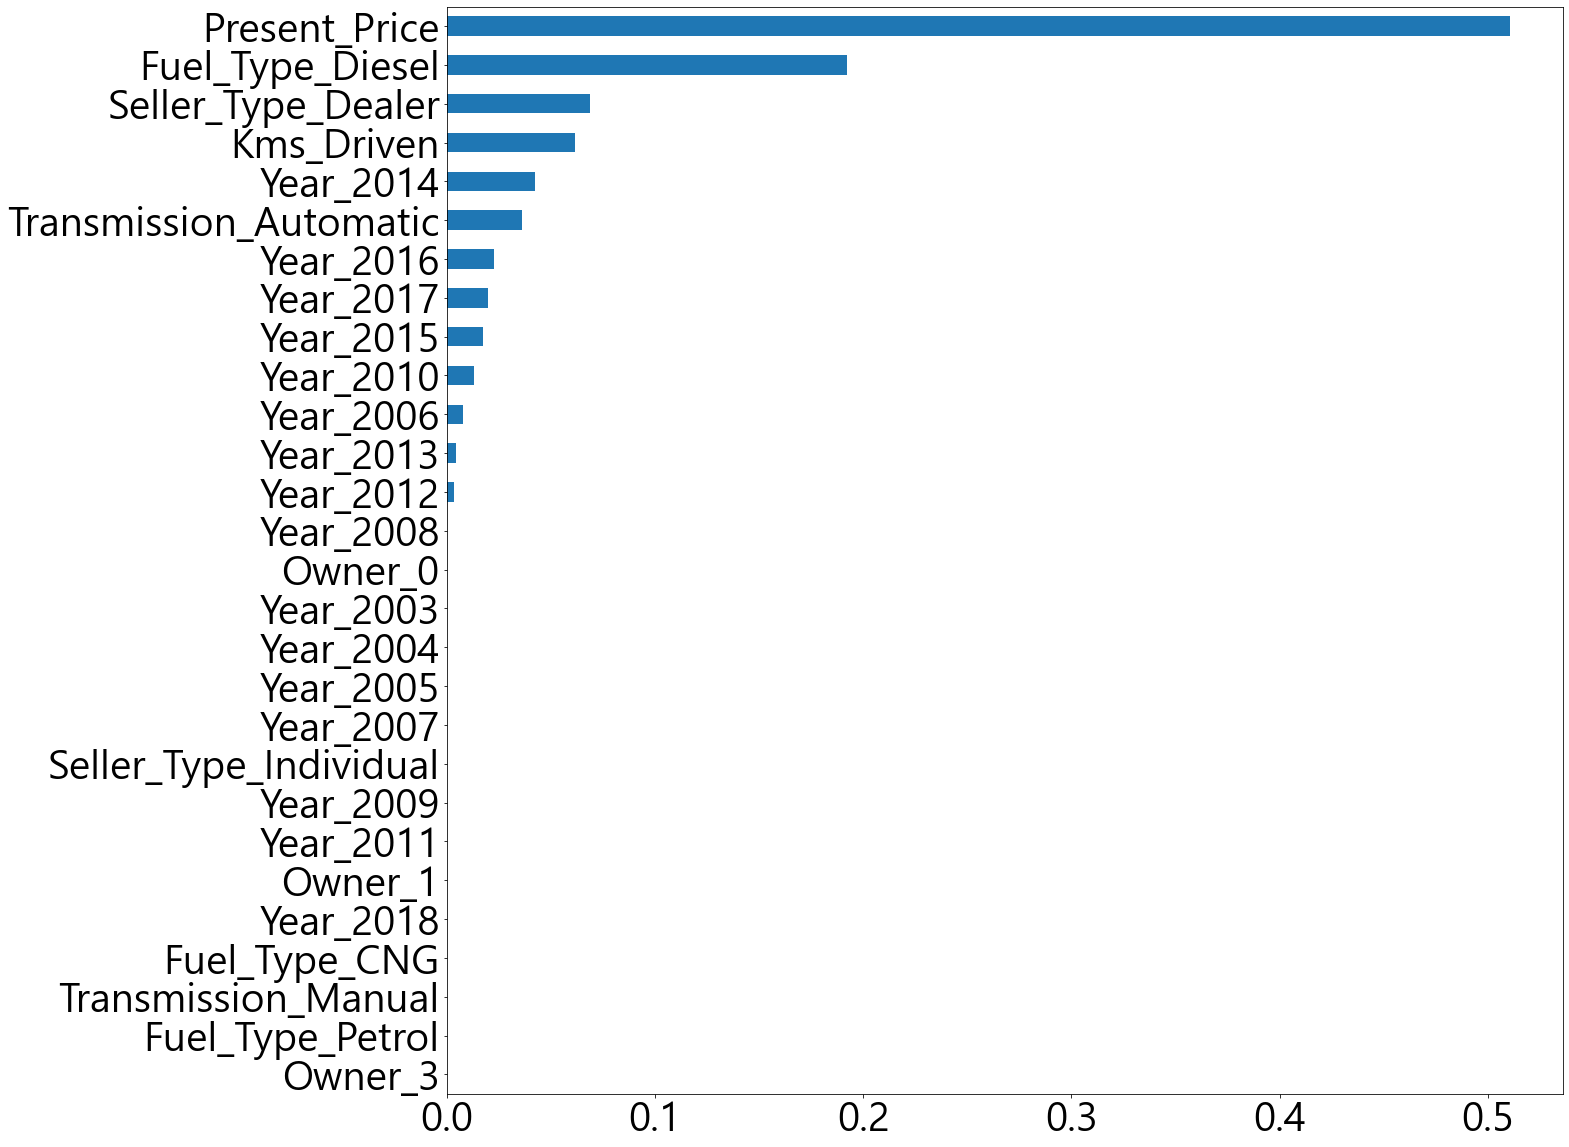

In [43]:
import pandas as pd
fi = pd.Series(best.feature_importances_, index=X.columns)
fi.sort_values(ascending=False)
fi.sort_values().plot(kind='barh', figsize=(20,20), fontsize=40)

- 연도를 범주형으로 넣었을 때 큰 중요도가 없는 것으로 보임
  - 주관적인 생각으로는 연도의 영향력 정확하지 않다 생각
  
## Data 개선 후 다시 학습
- 연도 수정
- 이상치 제거 X

In [44]:
# Year column을 범주형이 아닌 연속형으로 변환해 추가 후 Year 제거
df2 = df
df2['year'] = 2022-df2['Year']
df2.drop(columns='Year', inplace=True)
df2

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,year
Car_Name,,,,,,,,
ritz,3.35,5.59,27000,Petrol,Dealer,Manual,0,8
sx4,4.75,9.54,43000,Diesel,Dealer,Manual,0,9
ciaz,7.25,9.85,6900,Petrol,Dealer,Manual,0,5
wagon r,2.85,4.15,5200,Petrol,Dealer,Manual,0,11
swift,4.60,6.87,42450,Diesel,Dealer,Manual,0,8
...,...,...,...,...,...,...,...,...
city,9.50,11.60,33988,Diesel,Dealer,Manual,0,6
brio,4.00,5.90,60000,Petrol,Dealer,Manual,0,7
city,3.35,11.00,87934,Petrol,Dealer,Manual,0,13


In [45]:
# One-hot encoding
ohe2 = ['Fuel_Type','Seller_Type', 'Transmission', 'Owner']
df3 = pd.get_dummies(df2, columns= ohe2)   
y2 = df3['Selling_Price']
X2 = df3.drop(columns='Selling_Price')

# X(Feature), y(Label) 분리
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0)
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

# 전에 사용했던 model로 학습
xgb_random.fit(X_train2,y_train2)

C:\Users\oj\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 5.33217659e-01  1.84375298e-01  8.40263392e-01  6.54644102e-01
  6.89154598e-01  8.51542264e-01  5.08811010e-01             nan
  8.83382027e-01  8.87297957e-01  8.35230215e-01 -1.16405661e+03
  8.34005348e-01  5.41866920e-01  5.83656173e-01  7.30298098e-01
  6.48887783e-01  5.21208523e-01  7.33140302e-02             nan
  5.50681364e-01  7.91542272e-01  5.33080003e-01  7.89695803e-01
  7.82124104e-01  1.43205495e-01             nan  7.23781516e-01
  1.70987272e-01 -4.79689438e-01  7.75440679e-01  1.48989772e-01
  6.57990986e-01  7.76637642e-01  7.31359128e-01  6.44753271e-01
  7.80071304e-01  7.78085219e-01  8.38399231e-01  8.90571335e-01
             nan             nan -1.16401134e+03             nan
  6.85138082e-01  7.18518186e-01  7.61906506e-01             nan
  7.00128530e-01  7.56388337e-01             nan  1.67051611e-01
  8.701

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 1.5,
                                                          2, 2.5, 3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17],
                                        'n_estimators': [10, 20, 30, 50, 100,
                                                         150, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='r2')

In [46]:
# 검증
best2 = xgb_random.best_estimator_

pred_train2 = best2.predict(X_train2)
pred_test2 = best2.predict(X_test2)

print('train_mse : ',mean_squared_error(y_train2, pred_train2))
print('train_r2 : ',r2_score(y_train2, pred_train2))
print('test_mse : ',mean_squared_error(y_test2, pred_test2))
print('test_r2 : ',r2_score(y_test2, pred_test2))

train_mse :  0.23357680629219968
train_r2 :  0.9900503886849795
test_mse :  2.4626868821925605
test_r2 :  0.9229585469488104


- 평가지표 아주 조금 개선된 모습
- year의 영향력 증가

<AxesSubplot:>

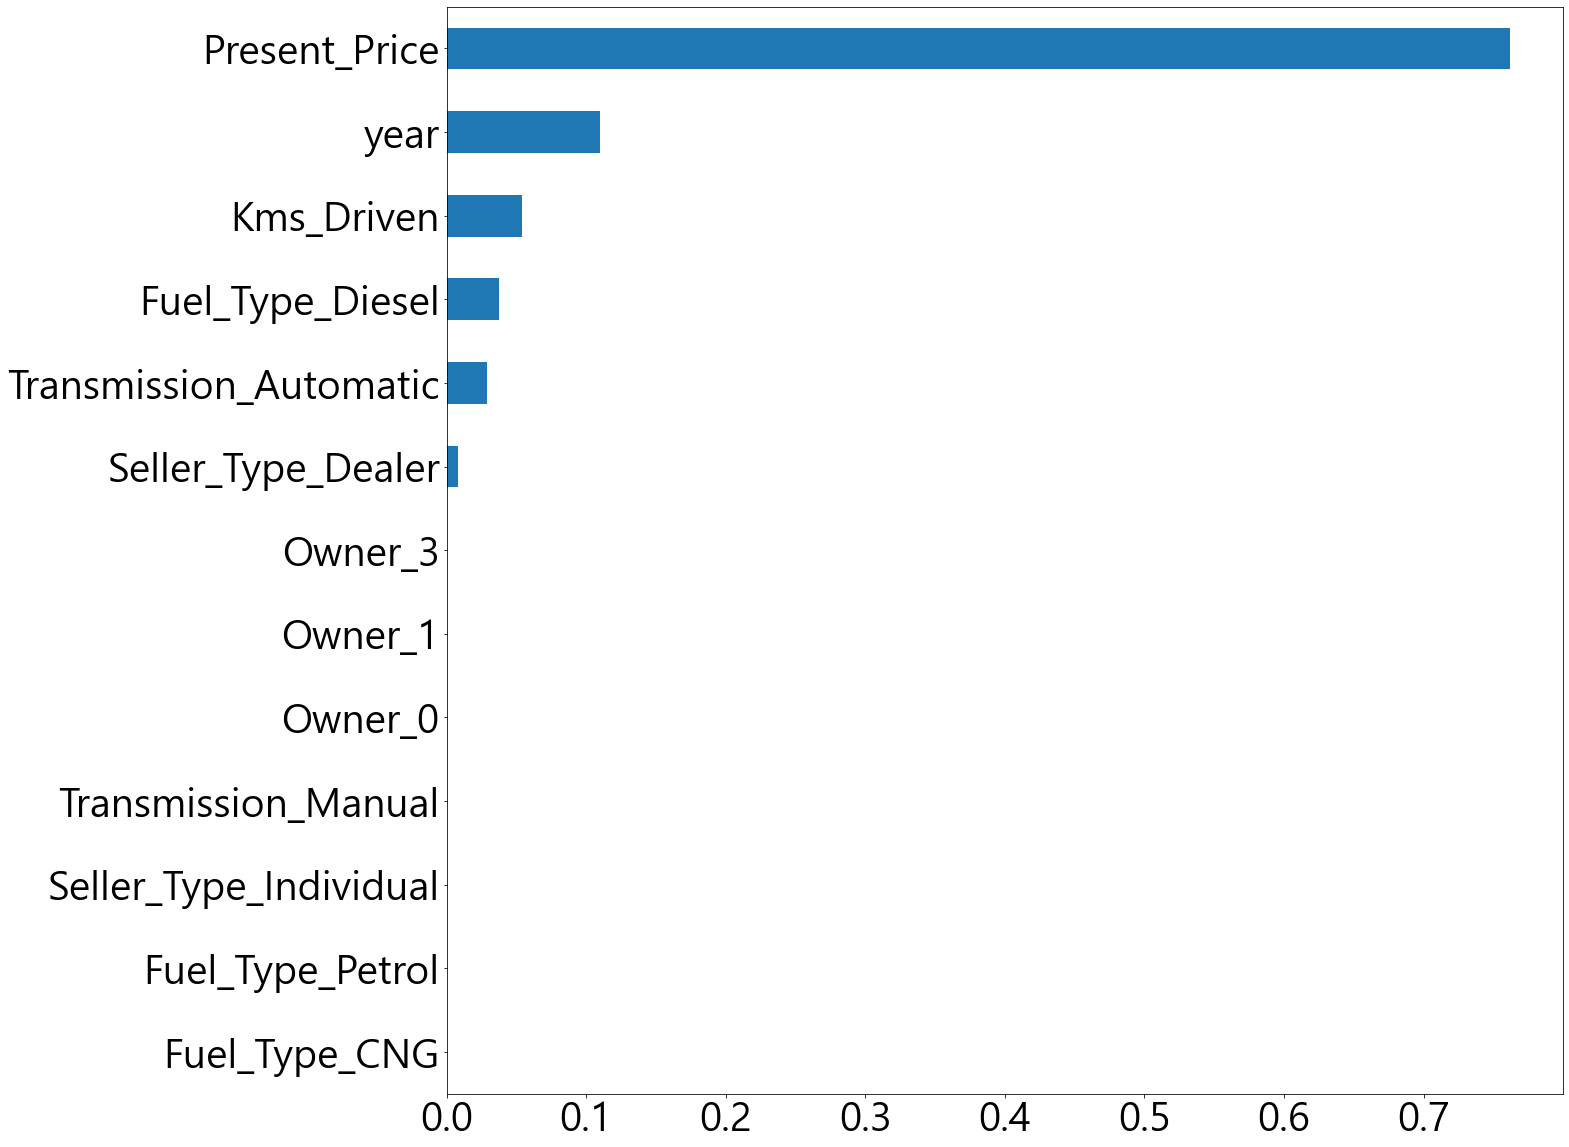

In [47]:
fi2 = pd.Series(best2.feature_importances_, index=X2.columns)
fi2.sort_values().plot(kind='barh', figsize=(20,20), fontsize=40)

In [48]:
# 상대적인 비율 확인 위해 영향력 0인 Feature 제거 후 pie chart
impo = best2.feature_importances_
changeValue = best2.feature_importances_
sto = []  
col = X2.columns
for i in range(len(changeValue)):
    if changeValue[i] == 0:
        sto.append(i)
impo = np.delete(impo, sto)
col = np.delete(col,sto)

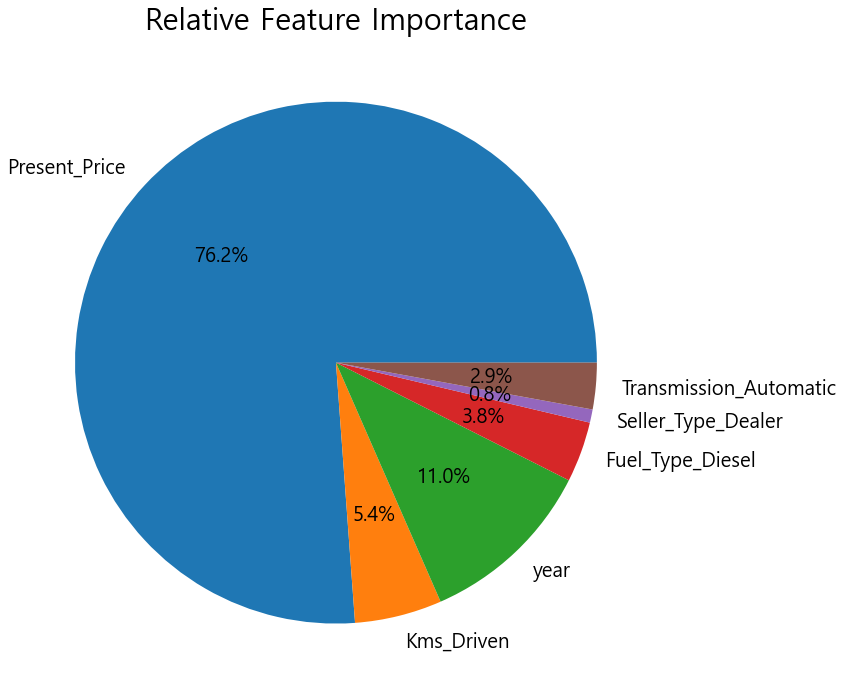

In [49]:
plt.figure(figsize=(12, 12))
plt.title('Relative Feature Importance',size=30)
plt.pie(impo, labels=col, autopct='%.1f%%',textprops={'fontsize': 20})
plt.show()

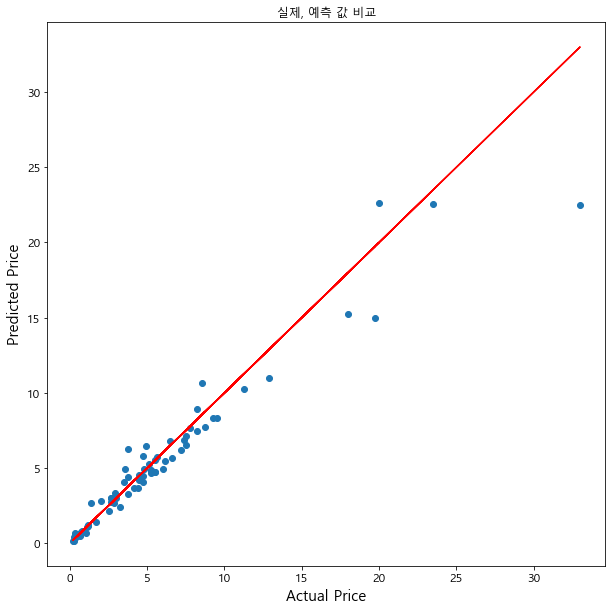

In [50]:
plt.figure(figsize=(10, 10))
plt.title('실제, 예측 값 비교')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.scatter(y_test2, pred_test2)
plt.plot(y_test2,y_test2,color='red')

# 결론
- 일정 가격 이상은 예측 확률 떨어지는 모습 관측할 수 있다
  - 이는 밑에서 보이는 것처럼 대다수의 Selling_Price 데이터가 일정 가격 이하에 포진되어있는 것이 원인이 된다고 생각한다
  - 일정 가격 이상의 데이터를 확보한다면 충분히 개선 가능할 것이라 생각한다

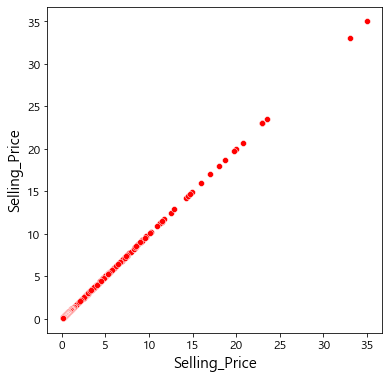

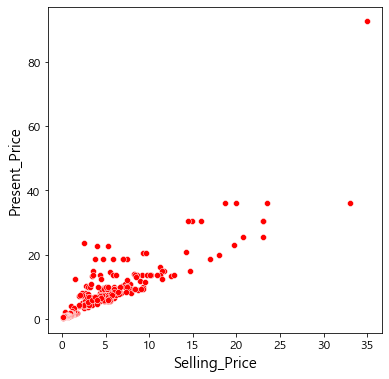

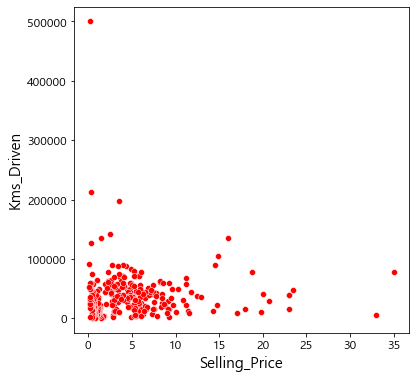

In [51]:
llist = ['Selling_Price', 'Present_Price', 'Kms_Driven']
df4 = df[llist]
for i in df4.columns:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x='Selling_Price', y=i, data=df, color='red')